# Identifying Fake Instagram Accounts

Growing a strong social media presence is important for some businesses. While a large number of followers is desirable, many Instagram growth tactics resort to boosting follower numbers through acquisition or purchase of robot or dummy accounts. These accounts provide no value to the influencer apart from artificially inflating the number of followers the influencer has. The presence of these fake accounts serves to dilute the engagement rates between influencers and their fans. Therefore, it is helpful to identify and remove such accounts from an influencer's page. For large influencer accounts with thousands of followers, the need to remove accounts in an automated way is necessary to reduce tedious work for an individual manageing a social-media presence--time better spent creating content and engaging with followers. 

Previously, simple methods based on follower-ratio or post count cut-offs have been used to reduce follower populations. Here, we instead investigate the use of machine learning models to identify fake accounts. To do so, the following steps have been taken:

### Model Development Steps

1. Collect a list of followers for an influencer instagram account
2. Scrape relevant statistics for each follower. Here, we use the following statistics:
    + Number of Posts
    + Number of Followers
    + Number of Following
3. Building a training set
    + Select a subset of followers
    + Manually label accounts as real or fake 
4. Test machine learning models
    + Compare several models
    + Feature engineering - try to create new features to improve model performance
5. Build production model from full training set
6. Apply model to identify fake accounts in test set
7. Takeaways
    + No (safe) automated way to remove accounts
    + Resort to growth

In [1]:
import json, itertools, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## 1. Collect follower list

This was done using the InstaPy library authored by Tim Grossman. 

Here is a sample of the results:

In [4]:
with open('../data/followers-27-11-2018~full~23501.json') as f:
    followers = json.load(f)
    
print('The client account has {} followers'.format(len(followers)))

The client account has 23501 followers


## 2. Scrape Follower Attributes

This was done by modifying the InstaPy source code to add functionality and extract post and follower counts. The following information was retreived and saved to a .csv file:

    + Number of Posts
    + Number of Followers
    + Number of accounts Followed

In [5]:
data = pd.read_csv('../data/follower-stats.txt', delim_whitespace=True)

# select columns to show for anonymity
cols_to_show = ['posts', 'followers', 'following']

data[cols_to_show].head()

,posts,followers,following
0,0,685,6700
1,278,2877,2093
2,229,1359,862
3,320,3071,7306
4,66,2505,388


Some of the scraped usernames returned no data. These entries must be removed from the data before training the model.

In [6]:
# Identify and remove usernames that have been changed
changed_users = data[data.posts=='None']['username']
changed_indices = changed_users.index
changed_user_names = changed_users.values

# create a dataframe with active users only
active_users = data.drop(labels=changed_indices)

print('There are {}  active followers \nFrom a total of {} original followers'.format(
    len(active_users), len(followers)))

There are 23375  active followers 
From a total of 23501 original followers


## 3. Build Training Set

+ Select subset
+ Manually label as Real/Fake

** Subset selection **

In [7]:
# There is also an option to use DataFrame.sample()

subset_percentage = 0.05

# training set - use a random_state for reproducability
data_train = active_users.sample(frac=subset_percentage, random_state=0)

# test set
data_test = active_users.drop(data_train.index)

** Manually Labeled Subset **

In [8]:
# Updated to standardize manual labels
labeled_train = pd.read_csv('../data/labeled_train_updated_tester_all.csv', index_col=0, usecols=[0,1,2,3,4,5,6])

cols_to_show_labeled = ['posts', 'followers', 'following', 'fake']
target_col = 'fake'

# clean up a bit
labeled_train.fake.replace(to_replace='o', value=0, inplace=True)
labeled_train.fake = labeled_train.fake.apply(lambda x: int(x))
labeled_train.fake.value_counts()

1    1037
0     132
Name: fake, dtype: int64

In [9]:
labeled_train.groupby('tester')['fake'].value_counts()

tester  fake
four    1       246
        0        24
one     1       256
        0        43
three   1       260
        0        40
two     1       275
        0        25
Name: fake, dtype: int64

** Tester 3 has a higher number of real accounts. Possibly less discerning **

+ Tester 3 is definitely more leninent (went from 100 to 40!)
+ Do the same for testers 2 and 4
+ Test without editing
+ If results are poor, re-visit and edit labels (7Ks)

### Feature Engineering

+ Ratio of followers/following
+ Numbers in username

In [10]:
labeled_train['ratio'] = labeled_train.followers/labeled_train.following
labeled_train['has_number'] = labeled_train.username.apply(lambda user: any(c.isdigit() for c in user)).astype(int)
labeled_train['ends_number'] = labeled_train.username.apply(lambda user: user[-1].isdigit()).astype(int)

eng_feats = ['ratio', 'has_number', 'ends_number']

cols_to_show_training = ['posts', 'followers', 
                         'following', 'fake', 'tester',
                         'ratio', 'has_number', 'ends_number']

labeled_train[cols_to_show_training].head()

,posts,followers,following,fake,tester,ratio,has_number,ends_number
14202,3,876,7202,0,one,0.121633,1,1
15214,61,81,5929,0,one,0.013662,1,0
7839,42,26,326,1,one,0.079755,0,0
16190,14,48,1454,0,one,0.033012,1,1
19924,32,207,6556,0,one,0.031574,0,0


Text(0.5,0,'# following')

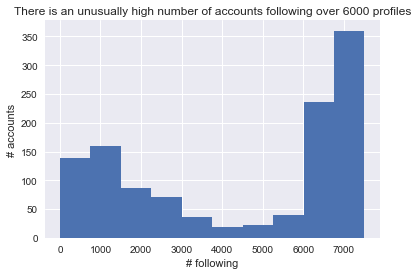

In [11]:
labeled_train.following.hist()
plt.title('There is an unusually high number of accounts following over 6000 profiles')
plt.ylabel('# accounts')
plt.xlabel('# following')

## 4. Learning Model Prototype

In [12]:
# define labels (this can change -- also this process can be automated to update different feature combinations)
X_labels = ['posts', 'followers', 'following', 'ratio', 'has_number', 'ends_number']
y_label = 'fake'

X = labeled_train[X_labels]
y = labeled_train[y_label]

**Split training and testing set**

Make sure all comparisons are made on the SAME split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [14]:
base_feats = ['posts', 'followers', 'following']
print('Base Features',base_feats)
print('Engineered Features:', eng_feats)

Base Features ['posts', 'followers', 'following']
Engineered Features: ['ratio', 'has_number', 'ends_number']


** Create a pipeline function to train & test model, print output **

In [15]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def evaluate_model(X, y, model_name, random_state=0, confusion=True):
    '''Select X features when calling the function
    
    Consider adding: Add k-fold, variance and mean
    '''
    
    # create train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    # get model
    model = model_name
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    
    # print metrics
    #print('--- /// BASE MODEL /// ---')
    print('--- Classification Report ---')
    print(classification_report(y_test, y_predicted, labels=[0,1], target_names=['Real', 'Fake']))
    print('--- Confusion Matrix ---')
    print(confusion_matrix(y_test, y_predicted))
    
    if confusion:
        plot_confusion_matrix(confusion_matrix(y_test, y_predicted), classes=['Real', 'Fake'],
                      title='Confusion matrix')
    else:
        pass

### Logistic Regression

+ Poor recall of underrepresented class (30% of Real Accounts)
+ Engineered features show no improvement of model performance

--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.82      0.30      0.44        30
       Fake       0.93      0.99      0.96       263

avg / total       0.91      0.92      0.90       293

--- Confusion Matrix ---
[[  9  21]
 [  2 261]]


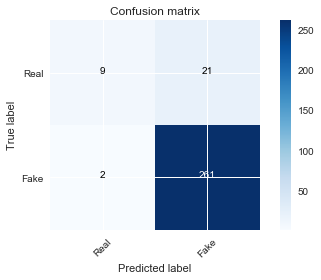

In [16]:
## BASE MODEL
evaluate_model(X[base_feats], y, LogisticRegression())

--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.85      0.37      0.51        30
       Fake       0.93      0.99      0.96       263

avg / total       0.92      0.93      0.92       293

--- Confusion Matrix ---
[[ 11  19]
 [  2 261]]


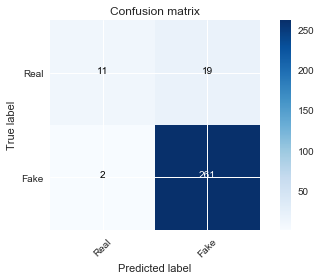

In [17]:
## ENGINEERED FEATURES
evaluate_model(X, y, LogisticRegression())

### Random Forest Classifier

+ More accurate than logistic regression
+ Higher recall (70% of Real accounts)
+ Engineered features improve performance slightly, but not significantly

--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.77      0.67      0.71        30
       Fake       0.96      0.98      0.97       263

avg / total       0.94      0.95      0.94       293

--- Confusion Matrix ---
[[ 20  10]
 [  6 257]]


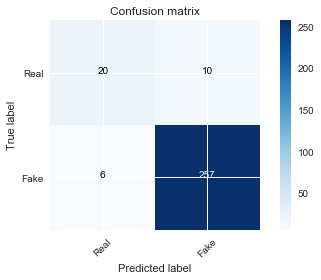

In [18]:
## BASE MODEL
evaluate_model(X[base_feats], y, RandomForestClassifier())

--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.75      0.70      0.72        30
       Fake       0.97      0.97      0.97       263

avg / total       0.94      0.95      0.94       293

--- Confusion Matrix ---
[[ 21   9]
 [  7 256]]


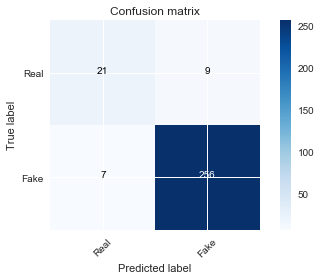

In [19]:
## ENGINEERED MODEL
evaluate_model(X, y, RandomForestClassifier())

** We want near 1.00 recall on real accounts. **

### KNN

+ Improves upon Logistic Regression, but not as good as Random Forest
+ Unsurprisignly, feature engineering makes no difference for nearest neighbors

--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.83      0.63      0.72        30
       Fake       0.96      0.98      0.97       263

avg / total       0.95      0.95      0.95       293

--- Confusion Matrix ---
[[ 19  11]
 [  4 259]]


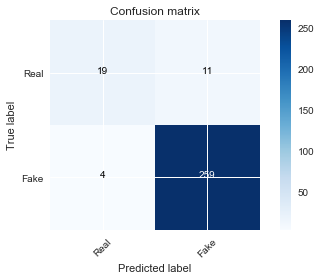

In [20]:
evaluate_model(X[base_feats], y, KNeighborsClassifier())

--- Classification Report ---
             precision    recall  f1-score   support

       Real       0.83      0.63      0.72        30
       Fake       0.96      0.98      0.97       263

avg / total       0.95      0.95      0.95       293

--- Confusion Matrix ---
[[ 19  11]
 [  4 259]]


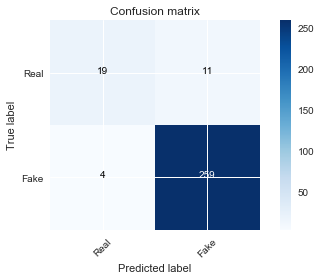

In [21]:
evaluate_model(X, y, KNeighborsClassifier())

### Additional Models 

The following models were tested, but not pursued further.

+ Naive Bayes (Gaussian) - extremely low recall (17%)
+ Decision Tree - low recall as well (55%)

### Sampling & K-fold cross-validation

+ The goal is to improve recall of the underrepresented (real) class
+ Undersampling and oversampling are both possible
+ Continue only with Random Forest model
+ Use stratified sampling as the classes are imbalanced

Undersampling proved to be too small to be reliable. Try oversampling.

In [22]:
# Instantiate and fit undersample model
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_sample(X, y)

# split train and test sets or perform kfold cross validation
#X_rus_train, X_rus_test, y_rus_train, y_rus_test = train_test_split(X_rus, y_rus, random_state=0)
skf = StratifiedKFold(n_splits=10, random_state=0)
print('There are {} splits for k-fold cross-validation'.format(skf.get_n_splits(X_rus, y_rus)))

There are 10 splits for k-fold cross-validation


In [23]:
print('RANDOM FOREST CLASSIFIER WITH UNDERSAMPLING')
acc_list = []; prec_list = []; rec_list = []
for k, (train, test) in enumerate(skf.split(X_rus, y_rus)):
    rfc_kfold = RandomForestClassifier()
    rfc_kfold.fit(X_rus[train], y_rus[train])
    y_pred_kfold = rfc_kfold.predict(X_rus[test])
    print('--- Fold {} ---'.format(k+1))
    accuracy, precision, recall, f1 = get_metrics(y_rus[test], y_pred_kfold)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    acc_list.append(accuracy)
    prec_list.append(precision)
    rec_list.append(recall)

print('Example Confusion Matrix')
print(confusion_matrix(y_rus[test], y_pred_kfold))    
# Summarize
print('Final Perfomance')
print('Accuracy: mean %.3f, variance %.3f' % (np.mean(acc_list), np.var(acc_list)))
print('Precision: mean %.3f, variance %.3f' % (np.mean(prec_list), np.var(prec_list)))
print('Recall: mean %.3f, variance %.3f' % (np.mean(rec_list), np.var(rec_list)))

RANDOM FOREST CLASSIFIER WITH UNDERSAMPLING
--- Fold 1 ---
accuracy = 0.786, precision = 0.850, recall = 0.786, f1 = 0.775
--- Fold 2 ---
accuracy = 0.964, precision = 0.967, recall = 0.964, f1 = 0.964
--- Fold 3 ---
accuracy = 0.885, precision = 0.887, recall = 0.885, f1 = 0.884
--- Fold 4 ---
accuracy = 0.923, precision = 0.933, recall = 0.923, f1 = 0.923
--- Fold 5 ---
accuracy = 0.962, precision = 0.964, recall = 0.962, f1 = 0.961
--- Fold 6 ---
accuracy = 0.808, precision = 0.810, recall = 0.808, f1 = 0.807
--- Fold 7 ---
accuracy = 0.962, precision = 0.964, recall = 0.962, f1 = 0.961
--- Fold 8 ---
accuracy = 0.923, precision = 0.923, recall = 0.923, f1 = 0.923
--- Fold 9 ---
accuracy = 0.885, precision = 0.887, recall = 0.885, f1 = 0.884
--- Fold 10 ---
accuracy = 0.923, precision = 0.923, recall = 0.923, f1 = 0.923
Example Confusion Matrix
[[12  1]
 [ 1 12]]
Final Perfomance
Accuracy: mean 0.902, variance 0.004
Precision: mean 0.911, variance 0.002
Recall: mean 0.902, variance 

### Oversampling 

+ Despite being very accurate, undersampling is too small. Only 26 samples are tested
+ Oversampling is significantly larger
+ And performs quite well
+ Accuracy, precision, and recall are all high (>97% with low variance)

In [24]:
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_sample(X, y)
X_ros_train, X_ros_test, y_ros_train, y_ros_test = train_test_split(X_ros, y_ros, random_state=0)

In [25]:
print('RANDOM FOREST CLASSIFIER WITH OVERSAMPLING')
acc_list = []; prec_list = []; rec_list = []
for k, (train, test) in enumerate(skf.split(X_ros, y_ros)):
    rfc_kfold = RandomForestClassifier()
    rfc_kfold.fit(X_ros[train], y_ros[train])
    y_pred_kfold = rfc_kfold.predict(X_ros[test])
    print('--- Fold {} ---'.format(k+1))
    accuracy, precision, recall, f1 = get_metrics(y_ros[test], y_pred_kfold)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    acc_list.append(accuracy)
    prec_list.append(precision)
    rec_list.append(recall)
    
print('Example Confusion Matrix')
print(confusion_matrix(y_ros[test], y_pred_kfold))    
# Summarize
print('Final Perfomance')
print('Accuracy: mean %.3f, variance %.3f' % (np.mean(acc_list), np.var(acc_list)))
print('Precision: mean %.3f, variance %.3f' % (np.mean(prec_list), np.var(prec_list)))
print('Recall: mean %.3f, variance %.3f' % (np.mean(rec_list), np.var(rec_list)))

RANDOM FOREST CLASSIFIER WITH OVERSAMPLING
--- Fold 1 ---
accuracy = 1.000, precision = 1.000, recall = 1.000, f1 = 1.000
--- Fold 2 ---
accuracy = 0.986, precision = 0.986, recall = 0.986, f1 = 0.986
--- Fold 3 ---
accuracy = 0.981, precision = 0.981, recall = 0.981, f1 = 0.981
--- Fold 4 ---
accuracy = 0.962, precision = 0.964, recall = 0.962, f1 = 0.961
--- Fold 5 ---
accuracy = 0.976, precision = 0.977, recall = 0.976, f1 = 0.976
--- Fold 6 ---
accuracy = 0.976, precision = 0.977, recall = 0.976, f1 = 0.976
--- Fold 7 ---
accuracy = 0.990, precision = 0.991, recall = 0.990, f1 = 0.990
--- Fold 8 ---
accuracy = 0.976, precision = 0.977, recall = 0.976, f1 = 0.976
--- Fold 9 ---
accuracy = 0.951, precision = 0.956, recall = 0.951, f1 = 0.951
--- Fold 10 ---
accuracy = 0.971, precision = 0.972, recall = 0.971, f1 = 0.971
Example Confusion Matrix
[[103   0]
 [  6  97]]
Final Perfomance
Accuracy: mean 0.977, variance 0.000
Precision: mean 0.978, variance 0.000
Recall: mean 0.977, varian

In [26]:
print('Set     Samples     Fakes')
print('Test:     ', len(y_ros[train]), '     ',sum(y_ros[train]))
print('Training:  ', len(y_ros[test]), '     ' ,sum(y_ros[test]))

Set     Samples     Fakes
Test:      1868       934
Training:   206       103


## 5. Training final model on full oversampled dataset

+ Base feature model
+ Engineered feature model

In [27]:
# base
rfc_base_final = RandomForestClassifier()
rfc_base_final.fit(X_ros[:,0:3], y_ros)
#pickle.dump(rfc_base_final, open('../models/final_rfc_base.sav', 'wb'))

# engineered
rfc_eng_final = RandomForestClassifier()
rfc_eng_final.fit(X_ros, y_ros)
#pickle.dump(rfc_eng_final, open('../models/final_rfc_eng.sav', 'wb'))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Demonstrate the model works

In [28]:
loaded_model = pickle.load(open('../models/final_rfc_base.sav', 'rb'))
loaded_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
print('Model Predictions:', loaded_model.predict(X_ros[0:20,0:3]))
print('Test Set Values:', y_ros[0:20])

Model Predictions: [0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1]
Test Set Values: [0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1]


## 6. Apply model to identify fake accounts in test set

In [33]:
unlabeled_test = pd.read_csv('../data/test.csv', index_col=0)
unlabeled_test['ratio'] = unlabeled_test.followers/unlabeled_test.following
unlabeled_test['has_number'] = unlabeled_test.username.apply(lambda user: any(c.isdigit() for c in user)).astype(int)
unlabeled_test['ends_number'] = unlabeled_test.username.apply(lambda user: user[-1].isdigit()).astype(int)
unlabeled_test.drop('username',axis=1).head()

,posts,followers,following,ratio,has_number,ends_number
0,0,685,6700,0.102239,0,0
1,278,2877,2093,1.374582,0,0
2,229,1359,862,1.576566,0,0
3,320,3071,7306,0.420339,0,0
4,66,2505,388,6.456186,0,0


In [34]:
loaded_rfc_model_base = pickle.load(open('../models/final_rfc_base.sav', 'rb'))
loaded_rfc_model_eng = pickle.load(open('../models/final_rfc_eng.sav', 'rb'))

In [35]:
y_unlabeled_test = loaded_rfc_model_eng.predict(unlabeled_test[base_feats+eng_feats])
unlabeled_test['fake'] = y_unlabeled_test
unlabeled_test.drop('username',axis=1).head()

,posts,followers,following,ratio,has_number,ends_number,fake
0,0,685,6700,0.102239,0,0,1
1,278,2877,2093,1.374582,0,0,0
2,229,1359,862,1.576566,0,0,0
3,320,3071,7306,0.420339,0,0,1
4,66,2505,388,6.456186,0,0,0


In [36]:
# get a list of real followers
real_test = unlabeled_test[unlabeled_test.fake==0].username.values
real_train = labeled_train[labeled_train.fake==0].username.values
real_followers = np.append(real_test, real_train)

# fake followers
fake_test = unlabeled_test[unlabeled_test.fake==1].username.values
fake_train = labeled_train[labeled_train.fake==1].username.values
fake_followers = np.append(fake_test, fake_train)

print('real: {}, fake: {}, total: {}'.format(len(real_followers), 
                                           len(fake_followers), 
                                           len(real_followers) + len(fake_followers)))

real: 2717, fake: 20658, total: 23375


## 7. Takeaways

### Types of Fakes

+ Over ~7K 
+ Abandoned accounts
+ Brazilian/Thai bot network - undesirable even if real 
+ Stolen photos
+ Generic photos
+ Inapporopriate content 
+ Incoherent post history

### Development & Evaluation Process

+ Simple algorithms
+ Feature engineering
+ Advanced algorithms
+ Comparison to standard methods (ie. cutoffs)
+ We want 0's -- we don't mind 1's, some fakes are OK--but we do not want to miss REAL followers. 
+ A high real recall score is necessary